In [174]:
import lifelines
import matplotlib.pyplot as plt
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
import pandas as pd
%matplotlib inline  
from functools import reduce
from math import log, exp
import operator

In [3]:
rossi = load_rossi()

In [5]:
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [29]:
def run_filtered_cox_ph(df, time_col, event_col, covariate_names ):
    df = df[covariate_names + [time_col, event_col]]
    cf = lifelines.CoxPHFitter() 
    cf.fit(df, time_col, event_col = event_col, include_likelihood= True)
    return cf

cf = run_cox_ph(rossi, "week", "arrest", ["paro", "prio"])



C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


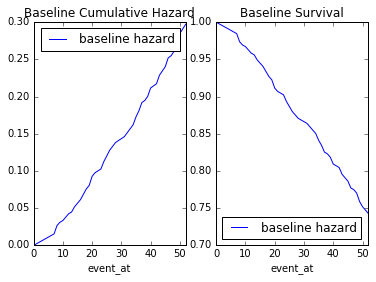

In [30]:
def present_cox_ph(cf):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True) 
    cf.baseline_cumulative_hazard_.plot(ax = axes[0], title = "Baseline Cumulative Hazard")
    cf.baseline_survival_.plot(ax = axes[1], title = "Baseline Survival")
present_cox_ph(cf)

In [217]:
class CoxPHModel: 
    
    def __init__(self, df, survival_col, cens_col, prior_params, reference_loglik = None, covariate_names = None):
        self.prior_params = prior_params
        self.survival_col = survival_col
        self.cens_col = cens_col
        
        all_covariate_columns = [col for col in df.columns if col not in [cens_col, survival_col]]
        if covariate_names == None:
            self.covariate_names = all_covariate_columns
        else:
            self.covariate_names = covariate_names
        self.df = df[self.covariate_names + [self.survival_col, self.cens_col]]
        
        self.mask = [x in self.covariate_names for x in all_covariate_columns]
        self._cf = None        
        if reference_loglik == None:
            reference_loglik = self.loglik()
        self.reference_loglik = reference_loglik
        
        
        
    def prior(self):
        parameter_contributions = [x[1] if x[0] else (1 - x[1]) for x in zip(self.mask , self.prior_params)]
        return reduce(operator.mul, parameter_contributions, 1)
    
    def _run(self):
        self._cf = lifelines.CoxPHFitter() 
        self._cf.fit(self.df, self.survival_col, event_col = self.cens_col, include_likelihood= True) 
    
    def loglik(self):
        if self._cf is None:
            self._run()
        return self._cf._log_likelihood
    
    def summary(self):
        if self._cf is None:
            self._run()
        return self._cf.summary.index, self._cf.summary["coef"], (self._cf.summary["se(coef)"] * self._cf.summary["se(coef)"])
    
    def bayesian_information_critera(self):
        size = len(self.covariate_names)
        n = self.df.shape[0]
        prior = self.prior()
        loglik = self.loglik()
        return (size * log(n)) - (2 * (loglik - self.reference_loglik)) - (2 * log(prior))

In [278]:
class BMACox:
    
    def __init__(self, x, survival_col, cens_col, priors = None):
        self.df = x
        self.survival_col = survival_col
        self.cens_col = cens_col
        if priors == None:
            self.priors = [0.5] * (len(self.df.columns) - 2) #Uniformative prior
        else:
            self.priors = priors
        self.reference_loglik = None
        self.full_model = self.create_model(None)
        self._set_reference_loglik()
       
    def _generate_model_definnitions(self):
        names, coefs, var = self.full_model.summary()
        model1 = ["fin", "prio"]
        model2 = ["race", "mar"]
        model6 = ["race", "age"]
        model3 = ["prio", "race"]
        model4 = ["prio", "race", "mar"]
        model5 = ["prio", "age", "mar"]
        return [model1, model2, model3, model4, model5, model6]
    
    def _weight_by_posterior(self, values, posterior):
        def add_dataframes(dfone, dftwo):
            return dfone.add(dftwo, fill_value = 0)
    
        output = zip(values, posterior)
        weighted = [x[0] * x[1] for x in output]
        running_total = weighted[0]
        for i in range(1, len(weighted)):
            running_total = add_dataframes(running_total, weighted[i])
        return running_total
    
    def run(self):
        
        models = self._generate_model_definnitions()
        models = [self.create_model(x) for x in models]
        bics = [x.bayesian_information_critera() for x in models]
        self.posterior_probabilities = []
        min_bic = min(bics)
        summation = sum( [exp(-0.5 * (bic - min_bic)) for bic in bics])
        for bic in bics:
            posterior = (exp(-0.5 * (bic - min_bic)))/summation
            self.posterior_probabilities.append(posterior)
        
        coefficiencts_by_model = [x.summary()[1] for x in models]
        sterr_by_model = [x.summary()[2] for x in models]
        
        self.coefficients_weighted = self._weight_by_posterior(coefficiencts_by_model, self.posterior_probabilities)
        self.sterr_weighted = self._weight_by_posterior(sterr_by_model, self.posterior_probabilities)
        return self.coefficients_weighted, self.sterr_weighted
    
    def create_model(self, covariate_names):
        return CoxPHModel(self.df, self.survival_col, self.cens_col, self.priors, self.reference_loglik, covariate_names)
    
    def _set_reference_loglik(self):
        self.reference_loglik = self.full_model.loglik()


In [279]:
bmaCox = BMACox(rossi, "week", "arrest")

posterior = bmaCox.run()
posterior[0]

C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


age    -0.358535
fin    -0.012678
mar    -0.145779
prio    0.264664
race    0.005098
Name: coef, dtype: float64

In [226]:
for x in posterior:
    print(x)

(fin    -0.199633
prio    0.301509
Name: coef, dtype: float64, 0.8390767051404825)
(race    0.065766
mar    -0.230589
Name: coef, dtype: float64, 0.0028389128986984536)
(prio    0.298192
race    0.102487
Name: coef, dtype: float64, 0.15808438196081923)


In [257]:
weighted = [x[0] * x[1] for x in p]
weighted

[fin    -0.167508
 prio    0.252989
 Name: coef, dtype: float64, race    0.000187
 mar    -0.000655
 Name: coef, dtype: float64, prio    0.047139
 race    0.016202
 Name: coef, dtype: float64]

In [260]:
def add_dataframes(dfone, dftwo):
    return dfone.add(dftwo, fill_value = 0)
running_total = weighted[0]
for i in range(1, len(weighted)):
    running_total = add_dataframes(running_total, weighted[i])
running_total

fin    -0.167508
mar    -0.000655
prio    0.300129
race    0.016388
Name: coef, dtype: float64

In [244]:
pd.DataFrame([0], columns = ["coef"])

,coef
0,0
